# Домашнее задание №3

### Пункт 1. Создание таблицы payments в базе данных SQL

#### В ячейку ниже впишите в двойных кавычках (" "):
* в переменную **_my__path_** путь вашей папки, в которой расположены папки *applications* и *contracts* (в путь включается название самой папки, в текущем примере папка со всеми данными называется IT)
* в переменную **_mydatabase_** название созданной вами базы данных
* в переменную **_mypassword_** ваш пользовательский пароль для работы с MySQL
* в переменную **_myuser_** ваше имя пользователя MySQL (по умолчанию *root*)

In [223]:
my_path = "C:/Users/plaps/Desktop/IT"
mydatabase = "loan"
mypassword = "MySQL2018"
myuser = "root"

In [277]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas.stats.api import ols
from os import listdir
from os.path import isfile, join
from datetime import datetime
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
from IPython.display import display, HTML
from sklearn import preprocessing
from datetime import timedelta
import mysql
import mysql.connector
from mysql.connector import Error
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import matplotlib.pyplot as plt
from sklearn import metrics
import statistics
import matplotlib as matplotlib
from decimal import Decimal
import math

ModuleNotFoundError: No module named 'stats'

In [225]:
# подключаемся к базе данных
database = mysql.connector.connect(user=myuser, password=mypassword,
                              host='localhost',
                              database=mydatabase,auth_plugin='mysql_native_password')
mycursor = database.cursor(buffered=True)

Данные рассматриваются на горизонте риска 1 год

In [226]:
years = 1
months = 0
days = 0

In [227]:
if type(years) != int or type(months) != int or type(days) != int:
    print('Ошибка: задайте целочисленные параметры!')

Выбираем на временном отрезке не менее заданного горизонта риска данные из объединенных таблиц applications, contracts и defaults  (только те данные, где известна дата начала контракта и длительность в месяцах). Получаем полную таблицу по заёмщику со всеми его характеристиками, включая метку с флагом дефолт - 1, не дефолт - 0 на заданном горизонте риска

In [228]:
mycursor.execute("""SELECT * FROM 
(SELECT DISTINCT applications.*, contracts.contract_number, contracts.amount, contracts.term_month, contracts.annuity, 
contracts.contract_date, contracts.type, defaults.default_date  
FROM applications
LEFT JOIN contracts 
ON applications.id_number = contracts.id_number
LEFT JOIN defaults
ON contracts.contract_number = defaults.contract_number
ORDER BY applications.id_number) t1
WHERE (t1.contract_date IS NOT NULL) 
AND (t1.term_month IS NOT NULL) 
AND DATE_ADD(t1.contract_date, INTERVAL (t1.term_month) MONTH) >= 
DATE_ADD(DATE_ADD(DATE_ADD(t1.contract_date, INTERVAL {0} YEAR), INTERVAL {1} MONTH), INTERVAL {2} DAY)""".format(years, 
                                                                                                                  months, days))
borrowers_defaults_data = mycursor.fetchall()
if not borrowers_defaults_data:
    print("Контракты такой длительности и более не найдены, выберите другой горизонт риска")
else:
    borrowers_defaults = pd.DataFrame(borrowers_defaults_data)
    borrowers_defaults.columns = [i[0] for i in mycursor.description]
    borrowers_defaults['default'] = 0
    borrowers_defaults.loc[borrowers_defaults['default_date']<= 
                           borrowers_defaults['contract_date']+relativedelta(days = days, months = months, years = years), 
                           'default'] = 1 #дефолты смотрим только на горизонте риска

Посмотрим на часть таблицы с заёмщиками с контрактами не менее заданного горизонта риска:

In [229]:
display(borrowers_defaults[['id_number', 'contract_number', 'amount', 'term_month', 'annuity', 'contract_date', 
                            'type', 'default_date', 'default']].head())

print("""Всего на промежутке времени не менее горизонта риска найдено заёмщиков с контрактом - """ +str(borrowers_defaults.shape[0])+""" ,
в текущей таблице максимально доступно полей (включая номер id заёмщика и номер контракта) -  """+str(borrowers_defaults.shape[1]))
print("Всего дефолтов на заданном горизонте риска - "+str(len(borrowers_defaults.loc[borrowers_defaults['default'] == 1])))

,id_number,contract_number,amount,term_month,annuity,contract_date,type,default_date,default
0,100003,100524,1293503,39,35699,2014-06-22,0,None,0
1,100004,100552,135000,23,6750,2017-08-01,1,None,0
2,100006,100493,312683,14,29687,2016-09-17,0,None,0
3,100007,100797,513000,26,21866,2017-06-09,0,None,0
4,100008,100929,490496,21,27518,2015-03-22,0,None,0


Всего на промежутке времени не менее горизонта риска найдено заёмщиков с контрактом - 60 ,
в текущей таблице максимально доступно полей (включая номер id заёмщика и номер контракта) -  24
Всего дефолтов на заданном горизонте риска - 1


Мы получили таблицу со всей информацией о заёмщике со всех таблиц, но нам нужны будут только с данными о дефолтах и релевантными данными из анкет, получим такую таблицу на горизонте риска 1 год:

Создаём список переменных по таблице applications, добавляем к нему параметр default

In [230]:
mycursor.execute("""SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_SCHEMA = '{0}' AND 
TABLE_NAME = 'applications'""".format(mydatabase))
applic_cols = mycursor.fetchall()
all_applic_cols = []
for i in range(0, len(applic_cols)):
    all_applic_cols.append(applic_cols[i][0])
all_applic_cols.append('default')

Создаем список, чтобы удалить лишние в анализе переменные (можно корректировать), например, id, даты? или переменные с кучей пропусков (как age_of_car)

In [231]:
drop_list = ['id_number','application_date','issue_date', 'age_of_car']
for i in drop_list:
    all_applic_cols.remove(i)

Все данные, которые понадобятся для анализа

In [232]:
borrowers_defaults_short = borrowers_defaults[all_applic_cols]
borrowers_defaults_short.head()

,children,family,income,age,education,employed_by,gender,house_ownership,housing,income_type,marital_status,position,default
0,0,2,270000,50,0,14,0,0,0,2,1,3.0,0
1,0,1,67500,54,2,5,1,1,0,3,3,5.0,0
2,0,2,135000,54,2,1,0,1,0,3,0,5.0,0
3,0,1,121500,55,2,13,1,1,0,3,3,3.0,0
4,0,2,99000,50,2,12,1,1,0,2,1,5.0,0


In [233]:
all_applic_cols.append('id_number')
borrowers_defaults_data = borrowers_defaults[all_applic_cols]
col = list(borrowers_defaults_data)
col.insert(0, col.pop(col.index('id_number')))
borrowers_defaults_data = borrowers_defaults_data.loc[:,col]
borrowers_defaults_data.head()

,id_number,children,family,income,age,education,employed_by,gender,house_ownership,housing,income_type,marital_status,position,default
0,100003,0,2,270000,50,0,14,0,0,0,2,1,3.0,0
1,100004,0,1,67500,54,2,5,1,1,0,3,3,5.0,0
2,100006,0,2,135000,54,2,1,0,1,0,3,0,5.0,0
3,100007,0,1,121500,55,2,13,1,1,0,3,3,3.0,0
4,100008,0,2,99000,50,2,12,1,1,0,2,1,5.0,0


Создадим список категориальных переменных, чтобы в дальнейшим именно по ним строить WOE

In [234]:
mycursor.execute("""SELECT DISTINCT column_name FROM applications_dict""")
char_vars =  mycursor.fetchall()
list_char_vars = []
for i in range(0, len(char_vars)):
    list_char_vars.append(char_vars[i][0])
additionally_append = ['family','children']  # что ещё считаем нужным рассматривать как категориальную
for i in range (0, len(additionally_append)):
    list_char_vars.append(additionally_append[i])

Для вычисления метрик WOE, IV, за основу взят код из ресурса https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb с некоторыми преобразованиями. По всем категориальным переменным применяется стандартная процедура вычисления WOE и IV, для непрерывных первоначально производится разбиение на категории. Данный код  категоризует по квантилям.

In [235]:
# define a binning function
def mono_bin(Y, X, max_bin, force_bin):
    n = max_bin
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True, sort = True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    np.seterr(divide='ignore')
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    np.seterr(divide='ignore')
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3["CATEGORY_NAME"] = "NO_CATEGORY"

    d3 = d3[['VAR_NAME', 'CATEGORY_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 
             'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True, sort = True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    np.seterr(divide='ignore')
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    np.seterr(divide='ignore')
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3["CATEGORY_NAME"] = "NO_CATEGORY"
    d3 = d3[['VAR_NAME','CATEGORY_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, default, max_bin, force_bin):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2 and i not in list_char_vars:
                conv = mono_bin(default, df1[i], max_bin, force_bin)
                conv["VAR_NAME"] = i
                for j in range(0, len(conv)):
                    conv.iloc[j, conv.columns.get_loc('CATEGORY_NAME')] = str(conv['MIN_VALUE'][j])+' - '+str(conv['MAX_VALUE'][j])
                
                count = count + 1
            else:
                conv = char_bin(default, df1[i])
                conv["VAR_NAME"] = i
                if i not in additionally_append:
                    mycursor.execute("""SELECT category, encoding FROM applications_dict WHERE column_name = '{0}' """.format(i))
                    keys = mycursor.fetchall()

                    for j in range(0, len(keys)):
                        conv.loc[conv['MIN_VALUE'] == keys[j][1], 'CATEGORY_NAME'] =  keys[j][0]
                else:
                    for j in range(0, len(conv)):
                        conv.iloc[j, conv.columns.get_loc('CATEGORY_NAME')] = str(conv['MIN_VALUE'][j])
                
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [236]:
max_bin = 10 # если WOE и разбиваем на бакеты
force_bin = 5

In [237]:
force_bin = force_bin+1
final_iv, IV = data_vars(borrowers_defaults_short.drop('default', axis=1),borrowers_defaults.default, max_bin, force_bin)

### Пункт b. Квантификация

Выведем таблиу со значениями WOE

In [238]:
final_iv

,VAR_NAME,CATEGORY_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,children,0,0.0,0.0,47,1.0,0.021277,46.0,0.978723,1.0,0.779661,0.248896,0.054842
1,children,1,1.0,1.0,12,0.0,0.000000,12.0,1.000000,0.0,0.203390,0.000000,0.054842
2,children,2,2.0,2.0,1,0.0,0.000000,1.0,1.000000,0.0,0.016949,0.000000,0.054842
3,family,1,1.0,1.0,14,0.0,0.000000,14.0,1.000000,0.0,0.237288,0.000000,0.233550
4,family,2,2.0,2.0,35,1.0,0.028571,34.0,0.971429,1.0,0.576271,0.551177,0.233550
5,family,3,3.0,3.0,10,0.0,0.000000,10.0,1.000000,0.0,0.169492,0.000000,0.233550
6,family,4,4.0,4.0,1,0.0,0.000000,1.0,1.000000,0.0,0.016949,0.000000,0.233550
7,income,38419 - 90000,38419.0,90000.0,15,0.0,0.000000,15.0,1.000000,0.0,0.254237,0.000000,1.878722
8,income,99000 - 112500,99000.0,112500.0,13,0.0,0.000000,13.0,1.000000,0.0,0.220339,0.000000,1.878722
9,income,121500 - 157500,121500.0,157500.0,8,1.0,0.125000,7.0,0.875000,1.0,0.118644,2.131627,1.878722


In [239]:
var_names = final_iv['VAR_NAME'].drop_duplicates().reset_index(drop=True)
for i in range(0,len(var_names)):
    list_WOE = final_iv[final_iv['VAR_NAME'] == var_names[i]]['WOE'].drop_duplicates().reset_index(drop=True)
    list_WOE = list(list_WOE)
    list_WOE.sort(reverse=True)
    for j in range(0, len(list_WOE)):
        if math.isnan(list_WOE[j]):
            list_WOE[j] = 'nan'
    if 'nan' in list_WOE:
        list_WOE.remove('nan')
    count = 0
    for j in range(0, len(list_WOE)):
        final_iv.loc[(final_iv['VAR_NAME'] == var_names[i]) & (final_iv['WOE'] == list_WOE[j]), 'Score_val'] = j+1
        count += 1
    for j in range(0, len(list_WOE)):
        final_iv.loc[(final_iv['VAR_NAME'] == var_names[i]) & 
                     (final_iv['WOE'] == list_WOE[j]), 'Score_val_norm'] ='%.0f' % round((j+1)/count*100, 0)

In [240]:
final_iv = final_iv[['VAR_NAME','CATEGORY_NAME', "MIN_VALUE", "MAX_VALUE", 'WOE', 'Score_val','Score_val_norm']]
final_iv = final_iv[np.isfinite(final_iv['Score_val'])].reset_index(drop = True)
final_iv.head(15)

,VAR_NAME,CATEGORY_NAME,MIN_VALUE,MAX_VALUE,WOE,Score_val,Score_val_norm
0,children,0,0.0,0.0,0.248896,1.0,50
1,children,1,1.0,1.0,0.000000,2.0,100
2,children,2,2.0,2.0,0.000000,2.0,100
3,family,1,1.0,1.0,0.000000,2.0,100
4,family,2,2.0,2.0,0.551177,1.0,50
5,family,3,3.0,3.0,0.000000,2.0,100
6,family,4,4.0,4.0,0.000000,2.0,100
7,income,38419 - 90000,38419.0,90000.0,0.000000,2.0,100
8,income,99000 - 112500,99000.0,112500.0,0.000000,2.0,100
9,income,121500 - 157500,121500.0,157500.0,2.131627,1.0,50


In [241]:
for i in range(0,len(final_iv)):
    var_name = final_iv['VAR_NAME'][i]
    borrowers_defaults_data.loc[(borrowers_defaults_data[var_name]>=final_iv['MIN_VALUE'][i]) & 
                                (borrowers_defaults_data[var_name]<=final_iv['MAX_VALUE'][i]), 
                                var_name+'_score'] = final_iv['Score_val_norm'][i]

In [242]:
borrowers_defaults_data_scored = borrowers_defaults_data.drop(var_names, axis= 1)
borrowers_defaults_data_scored.head(20)

,id_number,default,children_score,family_score,income_score,age_score,education_score,employed_by_score,gender_score,house_ownership_score,housing_score,income_type_score,marital_status_score,position_score
0,100003,0,50,50,100,100,100,100,50,50,50,100,100,100
1,100004,0,50,100,100,100,50,100,100,100,50,50,100,100
2,100006,0,50,50,50,100,50,100,50,100,50,50,50,100
3,100007,0,50,100,50,100,50,100,100,100,50,50,100,100
4,100008,0,50,50,100,100,50,100,100,100,50,100,100,100
5,100009,0,100,100,100,50,100,100,50,100,50,100,100,100
6,100010,0,50,50,100,100,100,100,100,100,50,100,100,100
7,100011,0,50,50,100,100,50,100,50,100,50,100,100,NaN
8,100012,0,50,100,50,50,50,100,100,100,50,50,100,100
9,100014,0,100,100,100,100,100,100,50,100,50,50,100,100


При выборе построения WOE также будет выводиться столбчатая диаграмма значений IV по убыванию для всех переменных

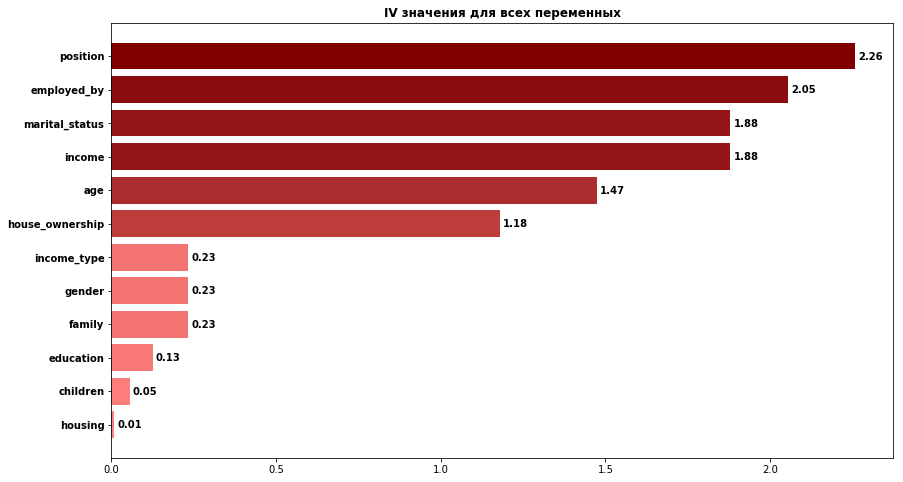

In [243]:
IV_sort = IV.sort_values('IV').reset_index()
iv_scores = np.array(IV_sort['IV'])
data_normalizer = matplotlib.colors.Normalize()
color_map = matplotlib.colors.LinearSegmentedColormap("my_map",{"red": [(0, 1.0, 1.0),(1.0, .5, .5)],
                                                                "green": [(0, 0.5, 0.5),(1.0, 0, 0)],
                                                                "blue": [(0, 0.50, 0.5),(1.0, 0, 0)]})

N = len(IV_sort['IV'])
x_nums = np.arange(1, N+1)

fig = plt.figure(1, [14, 8]) 
plt.barh(x_nums, IV_sort['IV'], align="center", color=color_map(data_normalizer(iv_scores)))
plt.yticks(x_nums, IV_sort['VAR_NAME'],  fontweight='bold')
for i, v in enumerate(iv_scores):
    #v = round(Decimal(v),2)
    plt.text(v+0.01, i+0.9, str(round(Decimal(v),2)), color='black',  fontweight='bold')
plt.title('IV значения для всех переменных', fontweight='bold')
plt.show()

Веса предлагается задавать на переменные в соответствии с приведенным выше ранжированием. Задайте произвольное значение для классов strong и medium

In [244]:
w_strong = 1.4 # пороги разделены по IV ранжированию, можно задать свои
w_medium = 1.1
w_weak = 1-w_strong-w_medium

In [245]:
IV_sort

,index,VAR_NAME,IV
0,7,housing,0.007505
1,1,children,0.054842
2,2,education,0.125161
3,4,family,0.233550
4,5,gender,0.233550
5,9,income_type,0.233550
6,6,house_ownership,1.179306
7,0,age,1.474113
8,8,income,1.878722
9,10,marital_status,1.878722


In [246]:
IV_sort.loc[IV_sort['IV'] >= 0.5, 'w_power'] = 'w_strong'
IV_sort.loc[(IV_sort['IV'] >= 0.15) &   (IV_sort['IV'] < 0.5), 'w_power'] = 'w_medium'     
IV_sort.loc[IV_sort['IV'] < 0.15, 'w_power'] = 'w_weak'                                         

In [247]:
list_w = ['w_strong', 'w_medium', 'w_weak']
for i in list_w:
    c = IV_sort['w_power'].value_counts()[i]
    IV_sort.loc[IV_sort['w_power'] == i, 'w_power2'] = 1/c

In [248]:
IV_sort

,index,VAR_NAME,IV,w_power,w_power2
0,7,housing,0.007505,w_weak,0.333333
1,1,children,0.054842,w_weak,0.333333
2,2,education,0.125161,w_weak,0.333333
3,4,family,0.233550,w_medium,0.333333
4,5,gender,0.233550,w_medium,0.333333
5,9,income_type,0.233550,w_medium,0.333333
6,6,house_ownership,1.179306,w_strong,0.166667
7,0,age,1.474113,w_strong,0.166667
8,8,income,1.878722,w_strong,0.166667
9,10,marital_status,1.878722,w_strong,0.166667


In [249]:
borrowers_defaults_data_scored = borrowers_defaults_data_scored.fillna(borrowers_defaults_data_scored.mean())

In [250]:
borrowers_defaults_data_scored.head()

,id_number,default,children_score,family_score,income_score,age_score,education_score,employed_by_score,gender_score,house_ownership_score,housing_score,income_type_score,marital_status_score,position_score
0,100003,0,50,50,100,100,100,100,50,50,50,100,100,100
1,100004,0,50,100,100,100,50,100,100,100,50,50,100,100
2,100006,0,50,50,50,100,50,100,50,100,50,50,50,100
3,100007,0,50,100,50,100,50,100,100,100,50,50,100,100
4,100008,0,50,50,100,100,50,100,100,100,50,100,100,100


In [274]:
s = 0
for i in range (0, len(borrowers_defaults_data_scored)):
    for j in var_names:
        print(list(IV_sort.loc[IV_sort['VAR_NAME'] == j]['w_power2'])[0])
        s  = s + borrowers_defaults_data_scored[j+'_score'][i]*float(raw_input(list(IV_sort.loc[IV_sort['VAR_NAME'] == j]['w_power2'])[0]))

0.3333333333333333


NameError: name 'raw_input' is not defined